In [211]:
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import fancyimpute
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import Imputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
%matplotlib inline

In [2]:
train_targets = pd.read_csv("../data/train_cli.tsv", delimiter="\t")
train_features = pd.read_csv("../data/train_pro.tsv", delimiter="\t")
train_rna_features = pd.read_csv("../data/train_rna.tsv", delimiter="\t")
test_targets = pd.read_csv("../data/test_cli.tsv", delimiter="\t")
test_features = pd.read_csv("../data/test_pro.tsv", delimiter="\t")
test_rna_features = pd.read_csv("../data/test_rna.tsv", delimiter="\t")
sum_tab1 = pd.read_csv("../data/sum_tab_1.csv")
sum_tab2 = pd.read_csv("../data/sum_tab_2.csv")

train_features = train_features.T.reset_index().drop('index', axis = 1)
train_rna_features = train_rna_features.T.reset_index().drop('index', axis = 1)
test_features = test_features.T.reset_index().drop('index', axis = 1)
test_rna_features = test_rna_features.T.reset_index().drop('index', axis = 1)

train_targets.drop('sample', axis = 1)
test_targets.drop('sample', axis = 1)

sum_tab1 = sum_tab1.drop('sample', axis = 1)
sum_tab2 = sum_tab2.drop('sample', axis = 1);

In [210]:
train_featuresshape = pd.read_csv("../data/train_pro.tsv", delimiter="\t")
train_featuresshape.shape

(4118, 80)

In [3]:
#Subchallenge #1 & 2
#Drop TMEM35A because column is full null
train_features = pd.DataFrame(train_features.dropna(axis = 1, how = 'all', thresh = 8))
# train_features.drop(['CT45A2', 'TKTL1'], axis = 0, inplace = True)
train_features_columns = list(train_features.columns)
train_features.shape

(80, 4082)

In [4]:
#Subchallenge #2
train_rna_features = pd.DataFrame(train_rna_features.dropna(axis = 1, how = 'all', thresh = 8))
train_rna_features_columns = list(train_rna_features.columns)
train_rna_features.shape

(80, 17336)

In [5]:
#Subchallenge #1 & 2
#Drop TMEM35A because column is full null
# test_features.drop('TMEM35A', axis = 0, inplace = True)
# test_features = pd.DataFrame(test_features.dropna(axis = 1, how = 'all', thresh = 8))
test_features = test_features[train_features_columns]

test_features.shape

(80, 4082)

In [6]:
#Subchallenge #2
# test_rna_features = pd.DataFrame(test_rna_features.T.dropna(axis = 1, how = 'all', thresh = 8))
# test_rna_features = test_rna_features.reset_index().drop('index', axis = 1)
test_rna_features = test_rna_features[train_rna_features_columns]
test_rna_features.shape

(80, 17336)

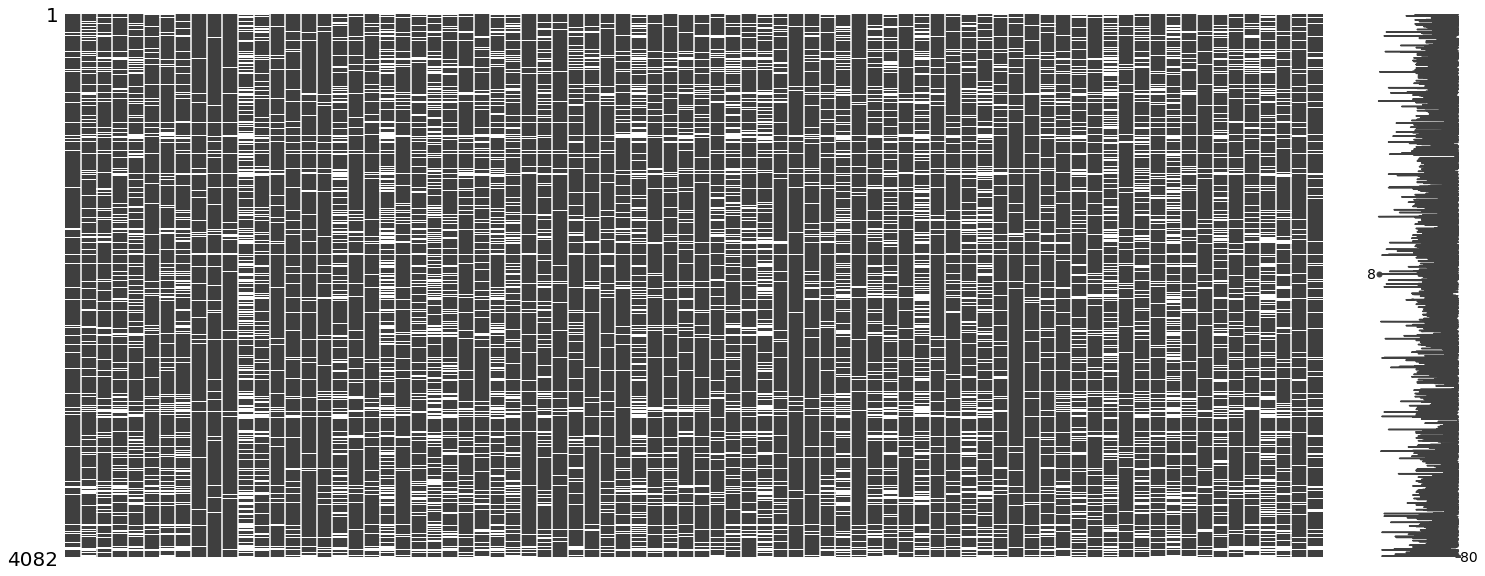

In [209]:
#Subchallenge #1
train_missingdata = train_features.T.columns[train_features.T.isnull().any()].tolist()
msno.matrix(train_features.T[train_missingdata]);

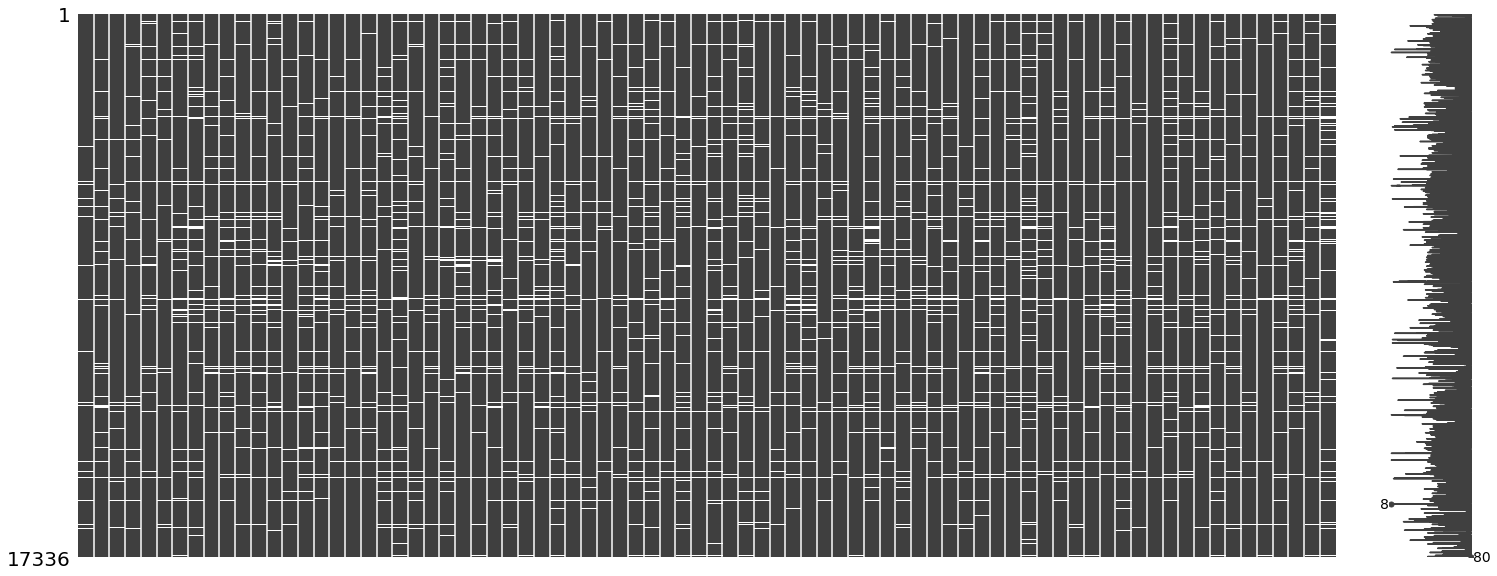

In [56]:
#Subchallenge #2
train_rna_missingdata = train_rna_features.T.columns[train_rna_features.T.isnull().any()].tolist()
msno.matrix(train_rna_features.T[train_rna_missingdata]);

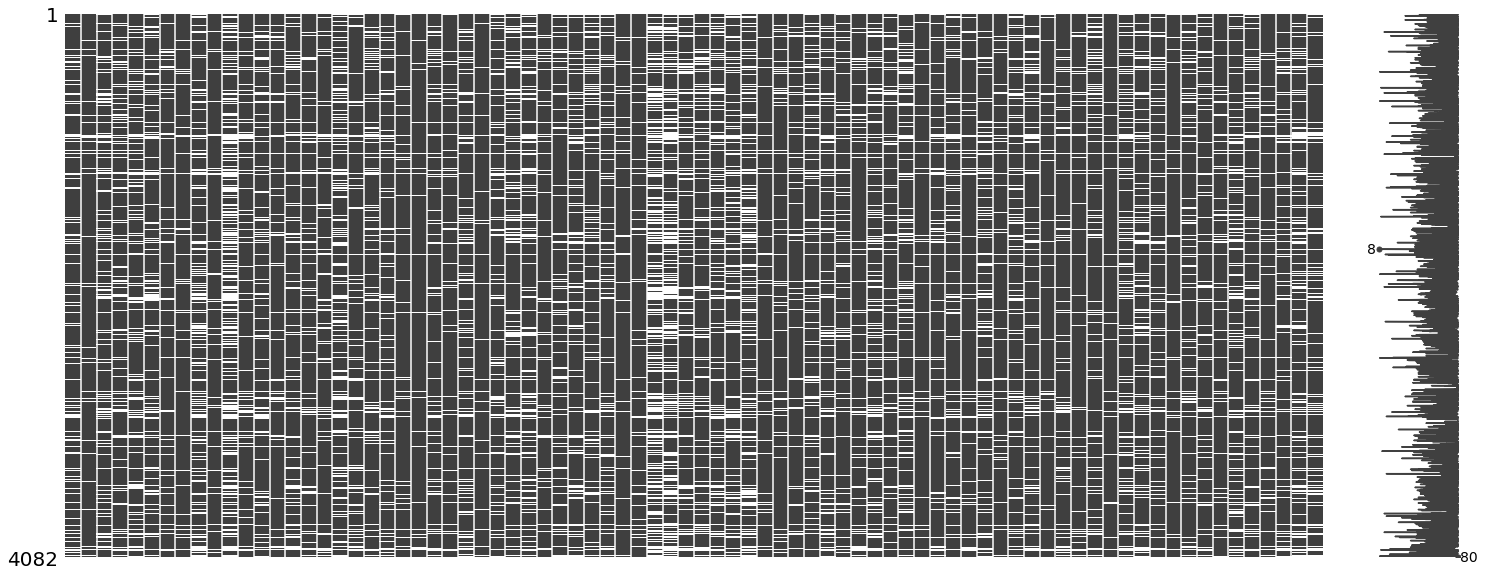

In [173]:
#Subchallenge #1
test_missingdata = test_features.T.columns[test_features.T.isnull().any()].tolist()
msno.matrix(test_features.T[test_missingdata]);

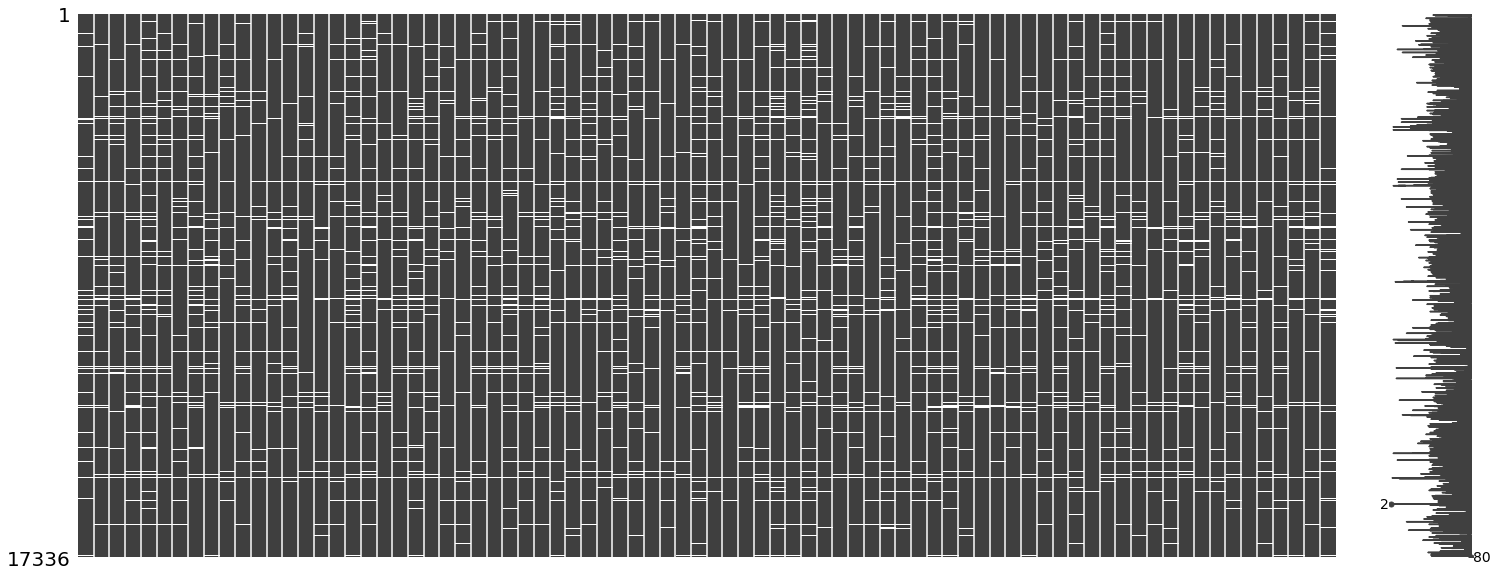

In [58]:
#Subchallenge #2
test_rna_missingdata = test_rna_features.T.columns[test_rna_features.T.isnull().any()].tolist()
msno.matrix(test_rna_features.T[test_rna_missingdata]);

In [7]:
#Subchallenge #2
train_features_w_rna = pd.concat([train_features, train_rna_features], axis = 1)
train_features_w_rna.shape

(80, 21418)

In [8]:
#Subchallenge #2
test_features_w_rna = pd.concat([test_features, test_rna_features], axis = 1)
test_features_w_rna.shape

(80, 21418)

In [62]:
#Subchallenge #2
#Create train_targets from sum_tab2
clin_sum_tab2 = sum_tab2['Clinical']
clin_sum_tab2 = sum_tab2['RNAseq']
clin_sum_tab2 = sum_tab2['Proteomics']
sum_tab2.head()

,Clinical,RNAseq,Proteomics
0,1,1,1
1,2,2,80
2,3,3,3
3,4,4,4
4,5,5,5


In [9]:
#Subchallenge #1
#Create train_features with converted 'gender' and 'msi' variables
train_targets['isfemale'] = train_targets['gender'].map( {'Male':0, 'Female':1} )
train_targets['isMSI-High'] = train_targets['msi'].map( {'MSI-Low/MSS':0, 'MSI-High':1} )
train_targets = train_targets.drop(['gender', 'msi', 'sample'], axis = 1)
train_targets = train_targets.convert_objects(convert_numeric=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


In [10]:
#Subchallenge #1
#Create test_df with converted 'gender' and 'msi' variables
test_targets['isfemale'] = test_targets['gender'].map( {'Male':0, 'Female':1} )
test_targets['isMSI-High'] = test_targets['msi'].map( {'MSI-Low/MSS':0, 'MSI-High':1} )
test_targets = test_targets.drop(['gender', 'msi', 'sample'], axis = 1)
test_targets = test_targets.convert_objects(convert_numeric=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


In [96]:
#Subchallenge #1
train_feature_list = list(train_features.columns)
test_feature_list = list(test_features.columns)

In [188]:
#Subchallenge #1
# Imputer Train_Features #1 KNN
# scaler = StandardScaler()  

# scaler.fit(train_features)
# train_features_knn = scaler.transform(train_features)  

# train_features_imputed_knn = pd.DataFrame(fancyimpute.KNN(k=5).fit_transform(train_features_knn))
# train_features_imputed_knn.columns = train_feature_list

#Imputer Test_Features #1 KNN
# scaler.fit(test_features)
# test_features_knn = scaler.transform(test_features) 

# test_features_imputed_knn = pd.DataFrame(fancyimpute.KNN(k=5).fit_transform(test_features_knn))
# test_features_imputed_knn.columns = test_feature_list

In [102]:
#Subchallenge #1
#Imputed Train Features #2a IterativeImputer
train_features_imputed_ii = pd.DataFrame(fancyimpute.IterativeImputer().fit_transform(train_features))
train_features_imputed_ii.columns = train_feature_list

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:957: RuntimeWarning: invalid value encountered in true_divide
  return (c / G_diag) ** 2, c
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:957: RuntimeWarning: invalid value encountered in true_divide
  return (c / G_diag) ** 2, c
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:957: RuntimeWarning: invalid value encountered in true_divide
  return (c / G_diag) ** 2, c
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:957: RuntimeWarning: invalid value encountered in true_divide
  return (c / G_diag) ** 2, c
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:957: RuntimeWarning: invalid value encountered in true_divide
  return (c / G_diag) ** 2, c
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:957: RuntimeWarning: invalid value encountered in true_divide
  return (c / G_diag) ** 2, c
/anaconda3/lib/python3.6/site-pack

In [108]:
#Subchallenge #1
# train_features_imputed_ii.to_csv('train_features_imputed_ii.csv')

In [109]:
#Subchallenge #1
#Imputed Test Features #2b IterativeImputer
test_features_imputed_ii = pd.DataFrame(fancyimpute.IterativeImputer().fit_transform(test_features))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:957: RuntimeWarning: invalid value encountered in true_divide
  return (c / G_diag) ** 2, c
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:957: RuntimeWarning: invalid value encountered in true_divide
  return (c / G_diag) ** 2, c
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:957: RuntimeWarning: invalid value encountered in true_divide
  return (c / G_diag) ** 2, c
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:957: RuntimeWarning: invalid value encountered in true_divide
  return (c / G_diag) ** 2, c
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:957: RuntimeWarning: invalid value encountered in true_divide
  return (c / G_diag) ** 2, c
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:957: RuntimeWarning: invalid value encountered in true_divide
  return (c / G_diag) ** 2, c
/anaconda3/lib/python3.6/site-pack

In [11]:
#Subchallenge #1
# test_features_imputed_ii.to_csv('test_features_imputed_ii.csv')
train_features_imputed_ii = pd.read_csv('train_features_imputed_ii.csv')
train_features_imputed_ii = train_features_imputed_ii.drop('Unnamed: 0', axis = 1)
test_features_imputed_ii = pd.read_csv('test_features_imputed_ii.csv')
test_features_imputed_ii = test_features_imputed_ii.drop('Unnamed: 0', axis = 1)

In [65]:
#Subchallenge #2
#Impute Train Features w RNA
train_features_w_rna_imputed_ii = pd.DataFrame(fancyimpute.IterativeImputer().fit_transform(train_features_w_rna))

In [66]:
#Subchallenge #2
train_features_w_rna_imputed_ii.to_csv('train_features_w_rna_imputed_ii.csv')
# train_features_w_rna_imputed_ii = pd.read_csv('train_features_w_rna_imputed_ii.csv')

In [68]:
#Subchallenge #2
#Impute Test Features w RNA
test_features_w_rna_imputed_ii = pd.DataFrame(fancyimpute.IterativeImputer().fit_transform(test_features_w_rna))

In [69]:
#Subchallenge #2
test_features_w_rna_imputed_ii.to_csv('test_features_w_rna_imputed_ii.csv')
# test_features_w_rna_imputed_ii = pd.read_csv('est_features_w_rna_imputed_ii.csv')

In [138]:
#Subchallenge #1
# Selecting Rows where mismatch = 0 or 1
# train_df_0 = train_df.loc[train_df['mismatch'] == 0]
# train_df_1 = train_df.loc[train_df['mismatch'] == 1]
# train_x_vars = train_df_0.drop(['mismatch'], axis = 1)
# train_y_vars = train_df_0['mismatch']

In [152]:
#Subchallenge #1
#IterativeImputer RandomForestClassifier -- Testing Currently on Train Data
model = RandomForestClassifier()
model.fit(train_features_imputed_ii[:55], train_targets[:55])
predicted_labels = model.predict(train_features_imputed_ii[56:])
print ("FINISHED classifying. accuracy score : ")
print (accuracy_score(train_targets[56:], predicted_labels))
# FINISHED classifying. accuracy score : 
# 0.375

FINISHED classifying. accuracy score : 
0.625


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [151]:
#Subchallenge #2
#IterativeImputer RandomForestClassifier 

# model2 = RandomForestClassifier()
# model2.fit(train_features_w_rna_imputed_ii, clin_sum_tab2)
# predicted_labels2 = pd.DataFrame(model2.predict(test_features_w_rna_imputed_ii)).astype('int')
# predicted_labels2.sort_values(by=0)

max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestClassifier(n_estimators=10000,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(train_features_w_rna_imputed_ii, sum_tab2)
y_multirf = regr_multirf.predict(test_features_w_rna_imputed_ii)
y_multirf = pd.DataFrame(y_multirf)

In [152]:
y_multirf.columns = [['Clinical', 'RNAseq', 'Proteomics']]

In [153]:
y_multirf.sort_values(y_multirf.columns[0], ascending = True)

,Clinical,RNAseq,Proteomics
67,1,4,20
32,4,54,36
0,5,1,20
79,7,7,7
73,9,1,9
9,9,9,9
60,9,9,20
25,9,1,20
76,11,11,20
3,11,11,11


In [133]:
y_multirf.to_csv('subchallenge_2.csv')

In [143]:
# #Subchallenge #1
# #KNNImputer RandomForestClassifier -- Testing Currently on Train Data
# model = RandomForestClassifier()
# model.fit(train_features_imputed_knn[:55], train_targets[:55])
# predicted_labels = model.predict(train_features_imputed_knn[56:])
# print ("FINISHED classifying. accuracy score : ")
# print (accuracy_score(train_targets[56:], predicted_labels))
# # FINISHED classifying. accuracy score : 
# # 0.35

FINISHED classifying. accuracy score : 
0.4166666666666667


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [140]:
#Subchallenge #1
# #SimpleImputer RandomForestClassifier -- Testing Currently on Train Data
# model = RandomForestClassifier()
# model.fit(train_features_imputed_si[:55], train_targets[:55])
# predicted_labels = model.predict(train_features_imputed_si[56:])
# print ("FINISHED classifying. accuracy score : ")
# print (accuracy_score(train_targets[56:], predicted_labels))
# # FINISHED classifying. accuracy score : 
# # 0.35

FINISHED classifying. accuracy score : 
0.4166666666666667


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
#Subchallenge #2 PCA
max_depth = 30
variance = .99
n_estimators = 100

scaler = StandardScaler()
scaler.fit(train_features_w_rna_imputed_ii)
train_rna_scaled = scaler.transform(train_features_w_rna_imputed_ii)
test_rna_scaled = scaler.transform(test_features_w_rna_imputed_ii)
pca = PCA(variance)
pca.fit(train_rna_scaled)
train_rna_pca = pca.transform(train_rna_scaled)
test_rna_pca = pca.transform(test_rna_scaled)

pca_multirf = MultiOutputRegressor(RandomForestClassifier(n_estimators=n_estimators,
                                                          max_depth=max_depth,
                                                          random_state=0))
pca_multirf.fit(train_rna_pca, sum_tab2)
y_pca = pca_multirf.predict(test_rna_pca)
y_pca = pd.DataFrame(y_pca)
y_pca.columns = [['Clinical', 'RNAseq', 'Proteomics']]
y_pca.sort_values(y_pca.columns[0], ascending = True)

In [15]:
train_concat_subc1 = pd.concat([train_features_imputed_ii,train_targets], axis =1)
test_concat_subc1 = pd.concat([test_features_imputed_ii,test_targets], axis =1)

In [156]:
Accuracy_ROCAUC = []

In [239]:
pd.set_option('display.max_rows', 100)

In [250]:
#Subchallenge #1 Random Forest
max_depth = 30
variance = .95
n_estimators = 100

# X_train, X_test, y_train, y_test = train_test_split(train_concat_subc1, sum_tab1['mismatch'],
#                                                     random_state=0,
#                                                     test_size=0.3)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# pca = PCA(variance)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# pca_rf_subc1_tts = RandomForestClassifier(n_estimators=n_estimators,
#                                                           max_depth=max_depth,
#                                                           random_state=123)
# pca_rf_subc1_tts.fit(X_train, y_train)
# y_pred = pca_rf_subc1_tts.predict(X_test)
# print('Accuracy' + str(accuracy_score(y_test, y_pred)))
# print('ROC AUC ' + str(roc_auc_score(y_test, y_pred)))
# Accuracy_ROCAUC.append(['Random Forest', str(accuracy_score(y_test, y_pred)),str(roc_auc_score(y_test, y_pred))])
# Accuracy_ROCAUC

# ####################################
scaler = StandardScaler()
X_train = scaler.fit_transform(train_concat_subc1)
X_test = scaler.transform(test_concat_subc1)
pca = PCA(variance)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

pca_rf_subc1 = RandomForestClassifier(n_estimators=n_estimators,
                                                          max_depth=max_depth,
                                                          random_state=123)
pca_rf_subc1.fit(X_train, sum_tab1['mismatch'])
y_pca_subc1 = pca_rf_subc1.predict(X_test)
y_pca_subc1 = pd.DataFrame(y_pca_subc1)
y_pca_subc1.sum()

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


0    0
dtype: int64

In [253]:
#Subchallenge #1 Logistic Regression
# X_train, X_test, y_train, y_test = train_test_split(train_concat_subc1, sum_tab1['mismatch'],
#                                                      random_state=0,
#                                                      test_size=0.3)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# pca = PCA(variance)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# logreg = LogisticRegression()
# logreg.fit(X_train,y_train)
# y_pred = logreg.predict(X_test)
# print('Accuracy ' + str(accuracy_score(y_test, y_pred)))
# print('ROC AUC ' + str(roc_auc_score(y_test, y_pred)))
# Accuracy_ROCAUC.append(['Logistic Regresssion', str(accuracy_score(y_test, y_pred)),str(roc_auc_score(y_test, y_pred))])
# Accuracy_ROCAUC

##########################################
scaler = StandardScaler()
X_train = scaler.fit_transform(train_concat_subc1)
X_test = scaler.transform(test_concat_subc1)
pca = PCA(variance)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train,sum_tab1['mismatch'])
y_pred = logreg.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_pred

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,0
0,1
1,1
2,1
3,1
4,1
5,0
6,1
7,1
8,1
9,0


In [291]:
#Subchallenge #1 SVM - Kernel - linear
# X_train, X_test, y_train, y_test = train_test_split(train_concat_subc1, sum_tab1['mismatch'],
#                                                      random_state=0,
#                                                      test_size=0.3)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# pca = PCA(variance)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)


# svm = SVC(kernel='linear', C=1E10)
# svm.fit(X_train,y_train)
# y_pred = svm.predict(X_test)
# print('Accuracy ' + str(accuracy_score(y_test, y_pred)))
# print('ROC AUC ' + str(roc_auc_score(y_test, y_pred)))
# Accuracy_ROCAUC.append(['SVM "linear"', str(accuracy_score(y_test, y_pred)),str(roc_auc_score(y_test, y_pred))])
# Accuracy_ROCAUC

##########################################
scaler = RobustScaler()
X_train = scaler.fit_transform(train_concat_subc1)
X_test = scaler.transform(test_concat_subc1)
pca = PCA(variance)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

svm = SVC(kernel='linear', C=1E10)
svm.fit(X_train,sum_tab1['mismatch'])
y_pred = svm.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_pred.sum()

,0
0,0
1,1
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [292]:
#Subchallenge #1 SVM - Kernel - rbf
# X_train, X_test, y_train, y_test = train_test_split(train_concat_subc1, sum_tab1['mismatch'],
#                                                      random_state=0,
#                                                      test_size=0.25)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# pca = PCA(variance)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)


# svm = SVC(kernel='rbf', C=1E10)
# svm.fit(X_train,y_train)
# y_pred = svm.predict(X_test)
# print('Accuracy' + str(accuracy_score(y_test, y_pred)))
# print('ROC AUC ' + str(roc_auc_score(y_test, y_pred)))
# Accuracy_ROCAUC.append(['SVM "rbf"', str(accuracy_score(y_test, y_pred)),str(roc_auc_score(y_test, y_pred))])
# Accuracy_ROCAUC

##########################################
scaler = StandardScaler()
X_train = scaler.fit_transform(train_concat_subc1)
X_test = scaler.transform(test_concat_subc1)
pca = PCA(variance)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

svm = SVC(kernel='rbf', C=1E10)
svm.fit(X_train,sum_tab1)
y_pred = svm.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_pred.sum()

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0    0
dtype: int64

In [285]:
#Subchallenge #1 Gaussian Naive Bayes
# X_train, X_test, y_train, y_test = train_test_split(train_concat_subc1, sum_tab1['mismatch'],
#                                                      random_state=0,
#                                                      test_size=0.3)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# pca = PCA(variance)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)


# nb = GaussianNB()
# nb.fit(X_train,y_train)
# y_pred = nb.predict(X_test)
# print('Accuracy ' + str(accuracy_score(y_test, y_pred)))
# print('ROC AUC ' + str(roc_auc_score(y_test, y_pred)))
# Accuracy_ROCAUC.append(['Gaussian Naive Bayes', str(accuracy_score(y_test, y_pred)),str(roc_auc_score(y_test, y_pred))])
# Accuracy_ROCAUC

##########################################
scaler = StandardScaler()
X_train = scaler.fit_transform(train_concat_subc1)
X_test = scaler.transform(test_concat_subc1)
pca = PCA(variance)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

nb = GaussianNB()
nb.fit(X_train,sum_tab1)
y_pred = nb.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_pred

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [247]:
#Subchallenge #1 XGBoost
# X_train, X_test, y_train, y_test = train_test_split(train_concat_subc1, sum_tab1['mismatch'],
#                                                      random_state=0,
#                                                      test_size=0.3)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# pca = PCA(variance)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# xgb = XGBClassifier()
# xgb.fit(X_train,y_train)
# y_pred = xgb.predict(X_test)
# print('Accuracy ' + str(accuracy_score(y_test, y_pred)))
# print('ROC AUC ' + str(roc_auc_score(y_test, y_pred)))
# Accuracy_ROCAUC.append(['XGBoost', str(accuracy_score(y_test, y_pred)),str(roc_auc_score(y_test, y_pred))])
# Accuracy_ROCAUC

##########################################
scaler = StandardScaler()
X_train = scaler.fit_transform(train_concat_subc1)
X_test = scaler.transform(test_concat_subc1)
pca = PCA(variance)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

xgb = XGBClassifier()
xgb.fit(X_train,sum_tab1['mismatch'])
y_pred = xgb.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_pred

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [279]:
#Subchallenge #1 MLP Neural Network
# X_train, X_test, y_train, y_test = train_test_split(train_concat_subc1, sum_tab1['mismatch'],
#                                                      random_state=0,
#                                                      test_size=0.35)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# pca = PCA(variance)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)


# mlp = MLPClassifier()
# mlp.fit(X_train,y_train)
# y_pred = mlp.predict(X_test)
# print('Accuracy ' + str(accuracy_score(y_test, y_pred)))
# print('ROC AUC ' + str(roc_auc_score(y_test, y_pred)))
# Accuracy_ROCAUC.append(['MLP Neural Network', str(accuracy_score(y_test, y_pred)),str(roc_auc_score(y_test, y_pred))])
# Accuracy_ROCAUC

# ##########################################
scaler = StandardScaler()
X_train = scaler.fit_transform(train_concat_subc1)
X_test = scaler.transform(test_concat_subc1)
pca = PCA(variance)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

mlp = MLPClassifier()
mlp.fit(X_train,sum_tab1['mismatch'])
y_pred = mlp.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_pred

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


,0
0,0
1,0
2,0
3,0
4,1
5,0
6,0
7,0
8,0
9,0


In [249]:
#Subchallenge #1 KNN
# X_train, X_test, y_train, y_test = train_test_split(train_concat_subc1, sum_tab1['mismatch'],
#                                                      random_state=0,
#                                                      test_size=0.3)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# pca = PCA(variance)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)


# knn = KNeighborsClassifier(n_neighbors=8)
# knn.fit(X_train,y_train)
# y_pred = knn.predict(X_test)
# print('Accuracy ' + str(accuracy_score(y_test, y_pred)))
# print('ROC AUC ' + str(roc_auc_score(y_test, y_pred)))
# Accuracy_ROCAUC.append(['MLP Neural Network', str(accuracy_score(y_test, y_pred)),str(roc_auc_score(y_test, y_pred))])
# Accuracy_ROCAUC

# krange = range(1, 15)
# training_error = []
# testing_error = []

# for k in krange:
    
#     #Instatiate
#     knn = KNeighborsClassifier(n_neighbors=k)
#     knn.fit(X_train, y_train)
    
#     #Training Error
#     training_acc = knn.score(X_train, y_train)
#     training_error.append(1- training_acc)
    
#     #Testing Error
#     testing_acc = knn.score(X_test, y_test)
#     testing_error.append(1- testing_acc)

# column_dict = {'K': krange, 'training error':training_error, 'testing error':testing_error}
# best_k = pd.DataFrame(column_dict).set_index('K').sort_index(ascending=False)
# best_k.head()

##########################################
scaler = StandardScaler()
X_train = scaler.fit_transform(train_concat_subc1)
X_test = scaler.transform(test_concat_subc1)
pca = PCA(variance)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train,sum_tab1['mismatch'])
y_pred = knn.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_pred

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


,training error,testing error
K,,
14,0.142857,0.166667
13,0.142857,0.166667
12,0.142857,0.166667
11,0.142857,0.166667
10,0.142857,0.166667
9,0.142857,0.166667
8,0.142857,0.166667
7,0.142857,0.208333
6,0.142857,0.208333


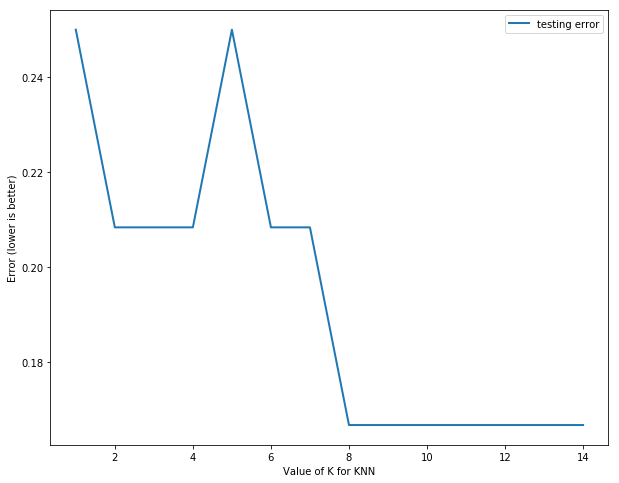

In [224]:
best_k.plot(y='testing error', linewidth=2, figsize=(10, 8));
plt.xlabel('Value of K for KNN');
plt.ylabel('Error (lower is better)');

best_k.sort_values('testing error')

In [172]:
Accuracy_ROCAUC = pd.DataFrame(Accuracy_ROCAUC)
Accuracy_ROCAUC.columns = [['Model', 'Accuracy Score', 'ROC AUC']]
Accuracy_ROCAUC

,Model,Accuracy Score,ROC AUC
0,Random Forest,0.8333333333333334,0.5
1,Logistic Regresssion,0.4583333333333333,0.375
2,"SVM ""linear""",0.8333333333333334,0.6
3,"SVM ""rbf""",0.9,0.5
4,Gaussian Naive Bayes,0.7916666666666666,0.575
5,XGBoost,0.8333333333333334,0.5
6,MLP Neural Network,0.6666666666666666,0.4


In [228]:
pca.n_components_

68

In [255]:
sum_tab1

,mismatch
0,0
1,1
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,1


In [288]:
sum_tab2

,Clinical,RNAseq,Proteomics
0,1,1,1
1,2,2,80
2,3,3,3
3,4,4,4
4,5,5,5
5,6,21,6
6,7,7,7
7,8,8,8
8,9,9,9
9,10,10,58
